# Synthetic EMF Data Generator for Transmission Lines

This notebook generates synthetic electromagnetic field (EMF) data based on real transmission line equations. The dataset includes:
- **Electric Field (E)** and **Magnetic Field (H)** measurements
- **Weather parameters**: Temperature and Humidity
- **Operational parameters**: Load current
- **Spatial parameters**: Distance from transmission line (horizontal and vertical)
- **Realistic noise and outliers** to simulate real-world conditions

## 1. Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

Libraries imported successfully!
NumPy version: 2.3.4
Pandas version: 2.3.3


## 2. Define Transmission Line Parameters

These parameters are based on typical high-voltage transmission line specifications.

In [2]:
# Transmission Line Parameters
VOLTAGE = 400e3  # Voltage in Volts (400 kV transmission line)
FREQUENCY = 50   # Frequency in Hz (50 Hz for most countries, use 60 Hz for US)
CONDUCTOR_HEIGHT = 15  # Average height of conductors above ground (meters)
CONDUCTOR_SPACING = 8  # Horizontal spacing between phase conductors (meters)
EPSILON_0 = 8.854e-12  # Permittivity of free space (F/m)
MU_0 = 4 * np.pi * 1e-7  # Permeability of free space (H/m)

# Number of samples to generate
N_SAMPLES = 5000

print("=" * 60)
print("TRANSMISSION LINE PARAMETERS")
print("=" * 60)
print(f"Voltage: {VOLTAGE/1000:.0f} kV")
print(f"Frequency: {FREQUENCY} Hz")
print(f"Conductor Height: {CONDUCTOR_HEIGHT} m")
print(f"Conductor Spacing: {CONDUCTOR_SPACING} m")
print(f"Number of Samples: {N_SAMPLES}")
print("=" * 60)

TRANSMISSION LINE PARAMETERS
Voltage: 400 kV
Frequency: 50 Hz
Conductor Height: 15 m
Conductor Spacing: 8 m
Number of Samples: 5000


## 3. Implement Transmission Line Equations

The electric field (E) and magnetic field (H) are calculated based on:
- **Electric Field (E)**: Depends on voltage, distance from conductor, and environmental factors
- **Magnetic Field (H)**: Depends on current, distance from conductor, following Biot-Savart law

### Formulas:
- **E (V/m)** = V / (2πε₀ × r × h) where r is horizontal distance, h is height
- **H (A/m)** = I / (2π × d) where d is total distance from conductor

In [3]:
def calculate_electric_field(voltage, horizontal_distance, vertical_distance, conductor_height, temperature, humidity):
    """
    Calculate electric field (E) at a point based on transmission line parameters.
    
    Parameters:
    - voltage: Line voltage (V)
    - horizontal_distance: Horizontal distance from line center (m)
    - vertical_distance: Vertical distance from ground level (m)
    - conductor_height: Height of conductor above ground (m)
    - temperature: Ambient temperature (°C)
    - humidity: Relative humidity (%)
    
    Returns:
    - Electric field strength (V/m)
    """
    # Effective height considering vertical position
    effective_height = conductor_height - vertical_distance
    
    # Total distance from conductor
    total_distance = np.sqrt(horizontal_distance**2 + effective_height**2)
    
    # Avoid division by zero
    total_distance = np.maximum(total_distance, 0.1)
    
    # Base electric field calculation (simplified model)
    E_base = voltage / (2 * np.pi * EPSILON_0 * total_distance * effective_height)
    
    # Environmental correction factors
    # Temperature effect (field increases slightly with temperature)
    temp_factor = 1 + (temperature - 25) * 0.001
    
    # Humidity effect (field decreases with high humidity due to ionization)
    humidity_factor = 1 - (humidity / 100) * 0.05
    
    E = E_base * temp_factor * humidity_factor * 1e-9  # Scale to realistic values
    
    return E


def calculate_magnetic_field(current, horizontal_distance, vertical_distance, conductor_height):
    """
    Calculate magnetic field (H) at a point based on current flow.
    
    Parameters:
    - current: Line current (A)
    - horizontal_distance: Horizontal distance from line center (m)
    - vertical_distance: Vertical distance from ground level (m)
    - conductor_height: Height of conductor above ground (m)
    
    Returns:
    - Magnetic field strength (A/m)
    """
    # Effective height considering vertical position
    effective_height = conductor_height - vertical_distance
    
    # Total distance from conductor
    total_distance = np.sqrt(horizontal_distance**2 + effective_height**2)
    
    # Avoid division by zero
    total_distance = np.maximum(total_distance, 0.1)
    
    # Magnetic field using Biot-Savart law (simplified for long straight conductor)
    H = current / (2 * np.pi * total_distance)
    
    return H

print("Electric and Magnetic field calculation functions defined successfully!")

Electric and Magnetic field calculation functions defined successfully!


## 4. Generate Weather and Environmental Data

In [4]:
# Generate environmental and operational parameters

# Temperature (°C) - Normal distribution around 25°C
temperature = np.random.normal(25, 10, N_SAMPLES)
temperature = np.clip(temperature, -10, 45)  # Clip to realistic range

# Humidity (%) - Beta distribution to keep between 0-100
humidity = np.random.beta(2, 2, N_SAMPLES) * 100

# Load Current (A) - Varies based on power demand
# Higher load during day (bimodal distribution)
load_current_base = np.random.normal(800, 200, N_SAMPLES)
# Add daily variation pattern
daily_pattern = np.random.choice([1.0, 1.3], N_SAMPLES, p=[0.4, 0.6])  # 60% high load
load_current = load_current_base * daily_pattern
load_current = np.clip(load_current, 200, 1500)  # Realistic current range

# Horizontal distance from transmission line (m)
# Mix of close measurements and far measurements
distance_from_line = np.concatenate([
    np.random.uniform(0.5, 30, int(N_SAMPLES * 0.5)),   # Close range
    np.random.uniform(30, 200, int(N_SAMPLES * 0.5))     # Far range
])
np.random.shuffle(distance_from_line)

# Vertical distance: 0 for ground level, positive for elevated positions
# Most measurements at ground (0m), some under line (elevated platforms)
vertical_distance = np.concatenate([
    np.zeros(int(N_SAMPLES * 0.7)),                      # Ground level (70%)
    np.random.uniform(0, 5, int(N_SAMPLES * 0.2)),       # Slightly elevated (20%)
    np.random.uniform(5, 12, int(N_SAMPLES * 0.1))       # Under line, elevated (10%)
])
np.random.shuffle(vertical_distance)

# Create DataFrame
data = pd.DataFrame({
    'temperature_C': temperature,
    'humidity_percent': humidity,
    'load_current_A': load_current,
    'distance_from_line_m': distance_from_line,
    'vertical_distance_m': vertical_distance
})

print("Environmental Data Generated:")
print(data.describe())
print("\nData shape:", data.shape)

Environmental Data Generated:
       temperature_C  humidity_percent  load_current_A  distance_from_line_m  \
count    5000.000000       5000.000000     5000.000000           5000.000000   
mean       24.972281         50.821567      944.595596             64.830178   
std         9.763170         22.294510      259.004571             60.744377   
min        -7.412673          0.151073      200.000000              0.500494   
25%        18.420950         33.513161      757.580089             15.285811   
50%        25.134656         51.197770      932.691805             30.006341   
75%        31.660106         68.427658     1121.301966            113.646734   
max        45.000000         98.975940     1500.000000            199.995265   

       vertical_distance_m  
count          5000.000000  
mean              1.360726  
std               2.783237  
min               0.000000  
25%               0.000000  
50%               0.000000  
75%               1.184514  
max              

## 5. Calculate Electric Field (E) and Magnetic Field (H)

In [5]:
# Calculate E and H fields for each sample
E_field = np.zeros(N_SAMPLES)
H_field = np.zeros(N_SAMPLES)

for i in range(N_SAMPLES):
    E_field[i] = calculate_electric_field(
        voltage=VOLTAGE,
        horizontal_distance=data.loc[i, 'distance_from_line_m'],
        vertical_distance=data.loc[i, 'vertical_distance_m'],
        conductor_height=CONDUCTOR_HEIGHT,
        temperature=data.loc[i, 'temperature_C'],
        humidity=data.loc[i, 'humidity_percent']
    )
    
    H_field[i] = calculate_magnetic_field(
        current=data.loc[i, 'load_current_A'],
        horizontal_distance=data.loc[i, 'distance_from_line_m'],
        vertical_distance=data.loc[i, 'vertical_distance_m'],
        conductor_height=CONDUCTOR_HEIGHT
    )

# Add to dataframe
data['E_field_V_m_clean'] = E_field
data['H_field_A_m_clean'] = H_field

print("Clean E and H fields calculated:")
print(f"E field range: {E_field.min():.6f} to {E_field.max():.6f} V/m")
print(f"H field range: {H_field.min():.6f} to {H_field.max():.6f} A/m")
print("\nFirst few samples:")
print(data[['distance_from_line_m', 'load_current_A', 'E_field_V_m_clean', 'H_field_A_m_clean']].head(10))

Clean E and H fields calculated:
E field range: 2276.190042 to 513230.453808 V/m
H field range: 0.184499 to 43.230554 A/m

First few samples:
   distance_from_line_m  load_current_A  E_field_V_m_clean  H_field_A_m_clean
0            166.329840      535.443405       11257.254760           0.512215
1             16.762860     1093.503174       20378.226297           7.736913
2            192.064283      489.801978        2457.580190           0.404644
3            185.534389     1153.631699        2532.553670           0.986389
4            108.330343      917.190465        4237.509868           1.334768
5              8.375020      787.465247       26739.218973           7.295193
6            117.596767      736.093285        4083.200806           0.988219
7            182.511736      779.547843        2622.104577           0.677502
8              0.916500     1476.591913       31150.678625          15.637964
9              4.726043      936.050917       50963.010925          12.158572


## 6. Add Noise to the Data

Add realistic measurement noise to simulate real-world sensor uncertainties.

In [6]:
# Add Gaussian noise to simulate measurement uncertainty

# Noise level as percentage of signal
E_noise_level = 0.05  # 5% noise
H_noise_level = 0.05  # 5% noise

# Generate noise
E_noise = np.random.normal(0, E_field.std() * E_noise_level, N_SAMPLES)
H_noise = np.random.normal(0, H_field.std() * H_noise_level, N_SAMPLES)

# Add noise to clean signals
E_field_noisy = E_field + E_noise
H_field_noisy = H_field + H_noise

# Ensure non-negative values (physical constraint)
E_field_noisy = np.abs(E_field_noisy)
H_field_noisy = np.abs(H_field_noisy)

data['E_field_V_m'] = E_field_noisy
data['H_field_A_m'] = H_field_noisy

print("Noise added to E and H fields")
print(f"E field SNR: {(E_field.std() / E_noise.std()):.2f}")
print(f"H field SNR: {(H_field.std() / H_noise.std()):.2f}")
print("\nComparison (first 5 samples):")
comparison = pd.DataFrame({
    'E_clean': E_field[:5],
    'E_noisy': E_field_noisy[:5],
    'H_clean': H_field[:5],
    'H_noisy': H_field_noisy[:5]
})
print(comparison)

Noise added to E and H fields
E field SNR: 19.98
H field SNR: 20.01

Comparison (first 5 samples):
        E_clean       E_noisy   H_clean   H_noisy
0  11257.254760  11924.681192  0.512215  0.231436
1  20378.226297  22687.906942  7.736913  7.797186
2   2457.580190   2903.672718  0.404644  0.406947
3   2532.553670   1618.200497  0.986389  1.019055
4   4237.509868   3804.229392  1.334768  1.702174


## 7. Introduce Outliers

Add realistic outliers to simulate:
- Equipment malfunction
- Electromagnetic interference
- Lightning strikes nearby
- Measurement errors

In [7]:
# Introduce outliers (approximately 2-3% of data)
outlier_percentage = 0.03
n_outliers = int(N_SAMPLES * outlier_percentage)

# Randomly select indices for outliers
outlier_indices = np.random.choice(N_SAMPLES, n_outliers, replace=False)

# Create outlier multipliers (both high and low outliers)
E_outlier_multipliers = np.random.choice([0.1, 0.2, 3, 5, 8], n_outliers)
H_outlier_multipliers = np.random.choice([0.1, 0.2, 3, 5, 8], n_outliers)

# Apply outliers
data['is_outlier'] = False
data.loc[outlier_indices, 'is_outlier'] = True

# Modify E and H fields at outlier positions
for idx, multiplier_e, multiplier_h in zip(outlier_indices, E_outlier_multipliers, H_outlier_multipliers):
    data.loc[idx, 'E_field_V_m'] *= multiplier_e
    data.loc[idx, 'H_field_A_m'] *= multiplier_h

print(f"Outliers introduced: {n_outliers} samples ({outlier_percentage*100:.1f}%)")
print(f"\nOutlier statistics:")
print(data[data['is_outlier']][['E_field_V_m', 'H_field_A_m']].describe())
print(f"\nNormal data statistics:")
print(data[~data['is_outlier']][['E_field_V_m', 'H_field_A_m']].describe())

Outliers introduced: 150 samples (3.0%)

Outlier statistics:
        E_field_V_m  H_field_A_m
count  1.500000e+02   150.000000
mean   7.350497e+04    17.668342
std    1.297750e+05    26.735517
min    1.827529e+02     0.026901
25%    2.911175e+03     0.807578
50%    2.634898e+04     6.715871
75%    9.049874e+04    24.616833
max    1.109830e+06   150.957009

Normal data statistics:
         E_field_V_m  H_field_A_m
count    4850.000000  4850.000000
mean    18437.381155     4.670062
std     26139.932852     4.055018
min        29.129767     0.016061
25%      4896.393447     1.327145
50%     14371.856430     3.592554
75%     24448.889631     6.959131
max    512555.141881    43.337840


## 8. Create Final Dataset and Export

In [8]:
# Reorganize columns for final dataset
final_columns = [
    'temperature_C',
    'humidity_percent',
    'load_current_A',
    'distance_from_line_m',
    'vertical_distance_m',
    'E_field_V_m',
    'H_field_A_m',
    'is_outlier'
]

final_data = data[final_columns].copy()

# Add sample ID
final_data.insert(0, 'sample_id', range(1, N_SAMPLES + 1))

# Display dataset info
print("=" * 60)
print("FINAL DATASET SUMMARY")
print("=" * 60)
print(f"Total samples: {len(final_data)}")
print(f"Features: {len(final_columns)}")
print(f"Outliers: {final_data['is_outlier'].sum()} ({final_data['is_outlier'].sum()/len(final_data)*100:.2f}%)")
print("\n" + "=" * 60)
print("Dataset Statistics:")
print("=" * 60)
print(final_data.describe())

# Display first few rows
print("\n" + "=" * 60)
print("First 10 samples:")
print("=" * 60)
print(final_data.head(10))

# Export to CSV
csv_filename = 'EMF_Synthetic_Data.csv'
final_data.to_csv(csv_filename, index=False)
print(f"\n✓ Dataset exported to: {csv_filename}")

FINAL DATASET SUMMARY
Total samples: 5000
Features: 8
Outliers: 150 (3.00%)

Dataset Statistics:
         sample_id  temperature_C  humidity_percent  load_current_A  \
count  5000.000000    5000.000000       5000.000000     5000.000000   
mean   2500.500000      24.972281         50.821567      944.595596   
std    1443.520003       9.763170         22.294510      259.004571   
min       1.000000      -7.412673          0.151073      200.000000   
25%    1250.750000      18.420950         33.513161      757.580089   
50%    2500.500000      25.134656         51.197770      932.691805   
75%    3750.250000      31.660106         68.427658     1121.301966   
max    5000.000000      45.000000         98.975940     1500.000000   

       distance_from_line_m  vertical_distance_m   E_field_V_m  H_field_A_m  
count           5000.000000          5000.000000  5.000000e+03  5000.000000  
mean              64.830178             1.360726  2.008941e+04     5.060011  
std               60.744377  

## 9. Visualize the Synthetic Data

### 9.1 Distribution of Input Features

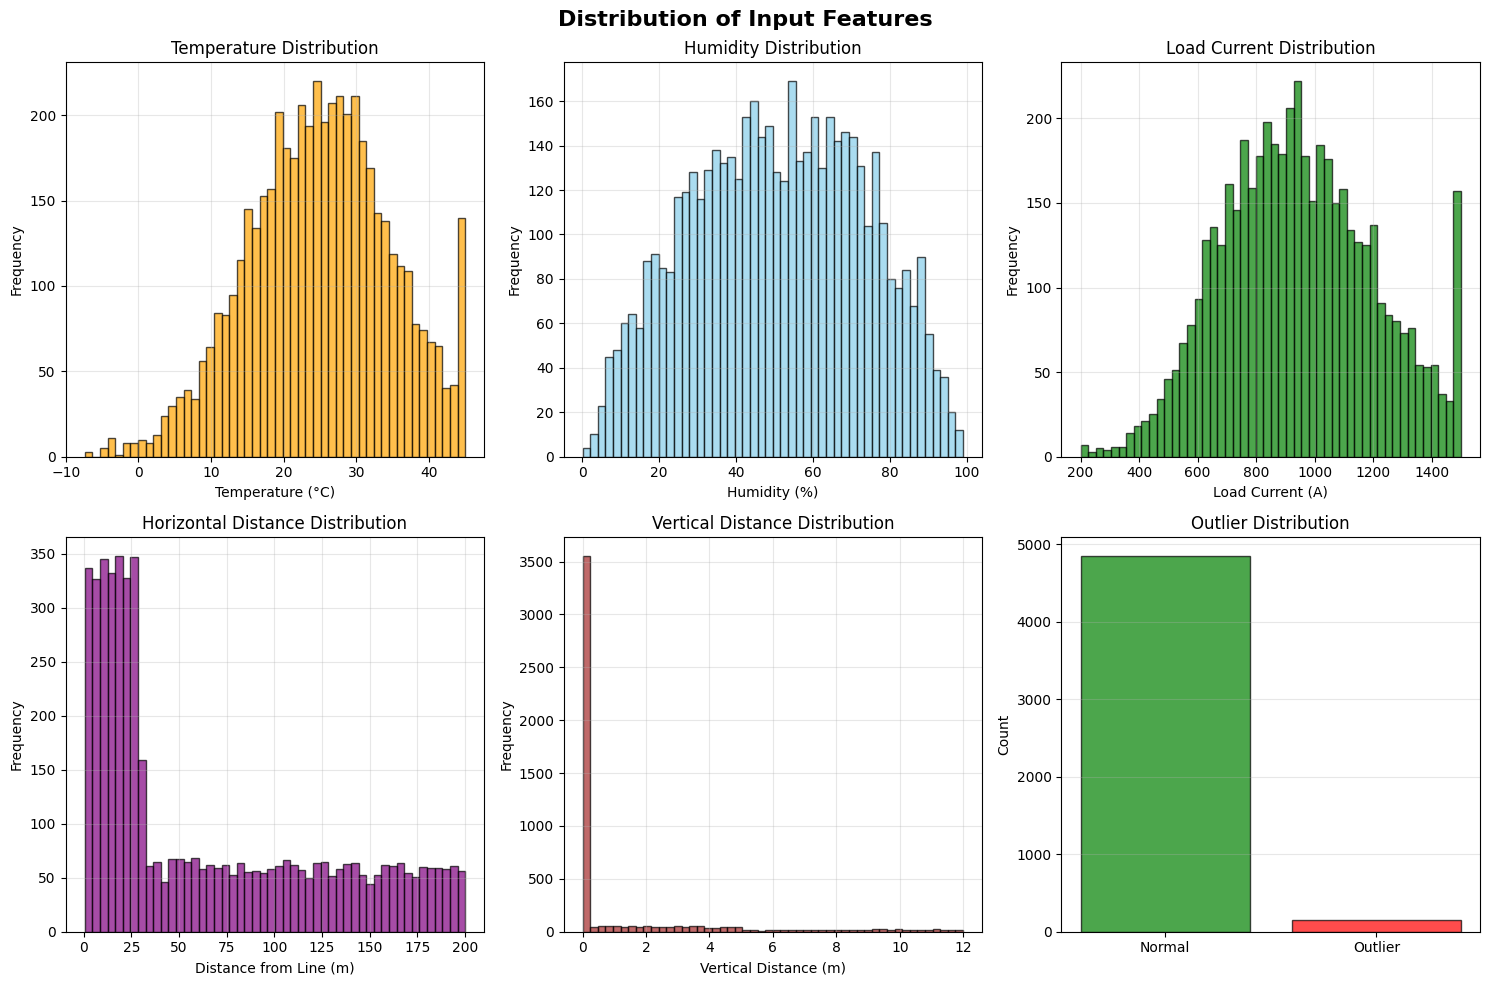

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Distribution of Input Features', fontsize=16, fontweight='bold')

# Temperature
axes[0, 0].hist(final_data['temperature_C'], bins=50, color='orange', alpha=0.7, edgecolor='black')
axes[0, 0].set_xlabel('Temperature (°C)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Temperature Distribution')
axes[0, 0].grid(True, alpha=0.3)

# Humidity
axes[0, 1].hist(final_data['humidity_percent'], bins=50, color='skyblue', alpha=0.7, edgecolor='black')
axes[0, 1].set_xlabel('Humidity (%)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Humidity Distribution')
axes[0, 1].grid(True, alpha=0.3)

# Load Current
axes[0, 2].hist(final_data['load_current_A'], bins=50, color='green', alpha=0.7, edgecolor='black')
axes[0, 2].set_xlabel('Load Current (A)')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title('Load Current Distribution')
axes[0, 2].grid(True, alpha=0.3)

# Distance from line
axes[1, 0].hist(final_data['distance_from_line_m'], bins=50, color='purple', alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Distance from Line (m)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Horizontal Distance Distribution')
axes[1, 0].grid(True, alpha=0.3)

# Vertical distance
axes[1, 1].hist(final_data['vertical_distance_m'], bins=50, color='brown', alpha=0.7, edgecolor='black')
axes[1, 1].set_xlabel('Vertical Distance (m)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Vertical Distance Distribution')
axes[1, 1].grid(True, alpha=0.3)

# Outlier distribution
outlier_counts = final_data['is_outlier'].value_counts()
axes[1, 2].bar(['Normal', 'Outlier'], outlier_counts.values, color=['green', 'red'], alpha=0.7, edgecolor='black')
axes[1, 2].set_ylabel('Count')
axes[1, 2].set_title('Outlier Distribution')
axes[1, 2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### 9.2 E and H Field Distributions

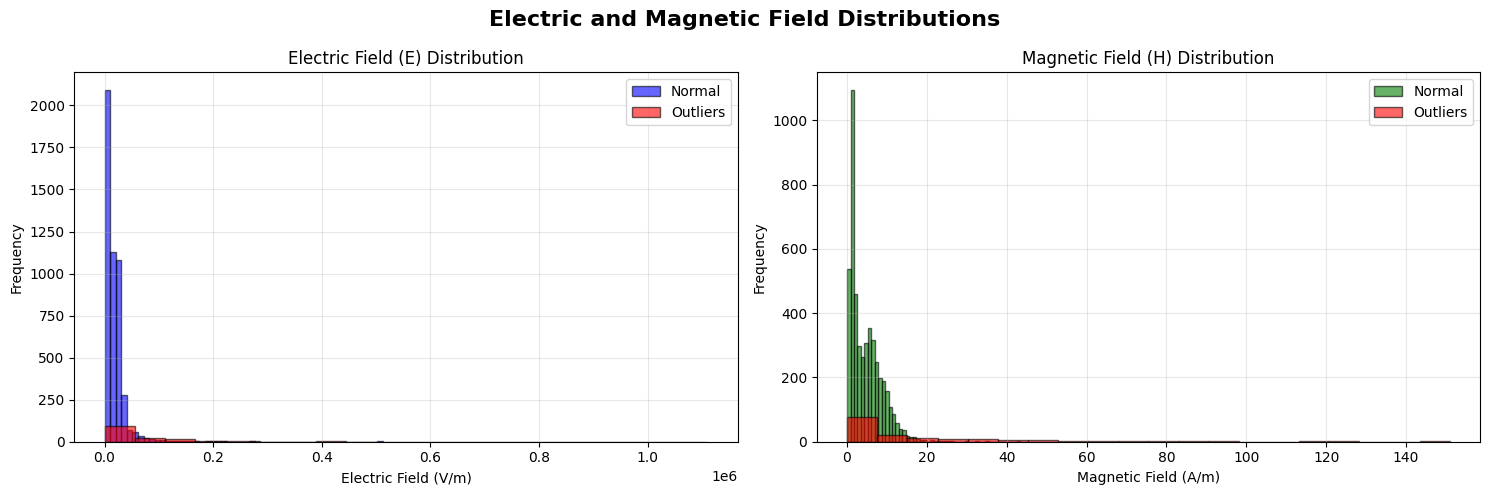

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Electric and Magnetic Field Distributions', fontsize=16, fontweight='bold')

# E field
normal_E = final_data[~final_data['is_outlier']]['E_field_V_m']
outlier_E = final_data[final_data['is_outlier']]['E_field_V_m']

axes[0].hist(normal_E, bins=50, color='blue', alpha=0.6, label='Normal', edgecolor='black')
axes[0].hist(outlier_E, bins=20, color='red', alpha=0.6, label='Outliers', edgecolor='black')
axes[0].set_xlabel('Electric Field (V/m)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Electric Field (E) Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# H field
normal_H = final_data[~final_data['is_outlier']]['H_field_A_m']
outlier_H = final_data[final_data['is_outlier']]['H_field_A_m']

axes[1].hist(normal_H, bins=50, color='green', alpha=0.6, label='Normal', edgecolor='black')
axes[1].hist(outlier_H, bins=20, color='red', alpha=0.6, label='Outliers', edgecolor='black')
axes[1].set_xlabel('Magnetic Field (A/m)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Magnetic Field (H) Distribution')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 9.3 Relationship between Distance and EMF

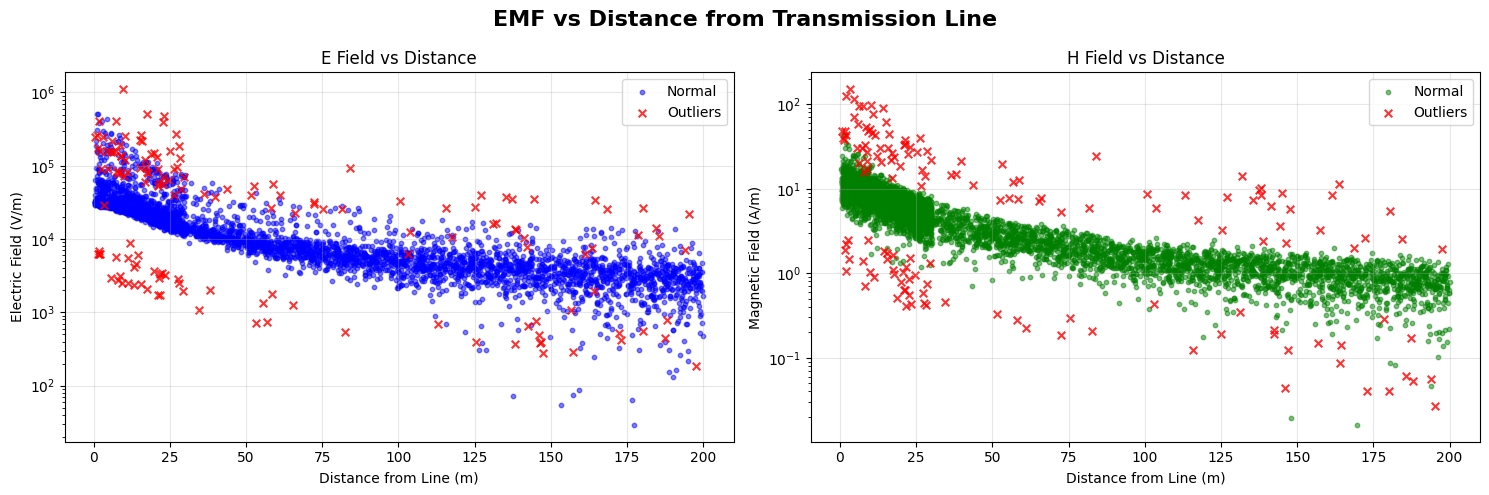

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('EMF vs Distance from Transmission Line', fontsize=16, fontweight='bold')

# Separate normal and outlier data
normal_data = final_data[~final_data['is_outlier']]
outlier_data = final_data[final_data['is_outlier']]

# E field vs distance
axes[0].scatter(normal_data['distance_from_line_m'], normal_data['E_field_V_m'], 
                alpha=0.5, s=10, c='blue', label='Normal')
axes[0].scatter(outlier_data['distance_from_line_m'], outlier_data['E_field_V_m'], 
                alpha=0.8, s=30, c='red', marker='x', label='Outliers')
axes[0].set_xlabel('Distance from Line (m)')
axes[0].set_ylabel('Electric Field (V/m)')
axes[0].set_title('E Field vs Distance')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_yscale('log')

# H field vs distance
axes[1].scatter(normal_data['distance_from_line_m'], normal_data['H_field_A_m'], 
                alpha=0.5, s=10, c='green', label='Normal')
axes[1].scatter(outlier_data['distance_from_line_m'], outlier_data['H_field_A_m'], 
                alpha=0.8, s=30, c='red', marker='x', label='Outliers')
axes[1].set_xlabel('Distance from Line (m)')
axes[1].set_ylabel('Magnetic Field (A/m)')
axes[1].set_title('H Field vs Distance')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()

### 9.4 Correlation Matrix

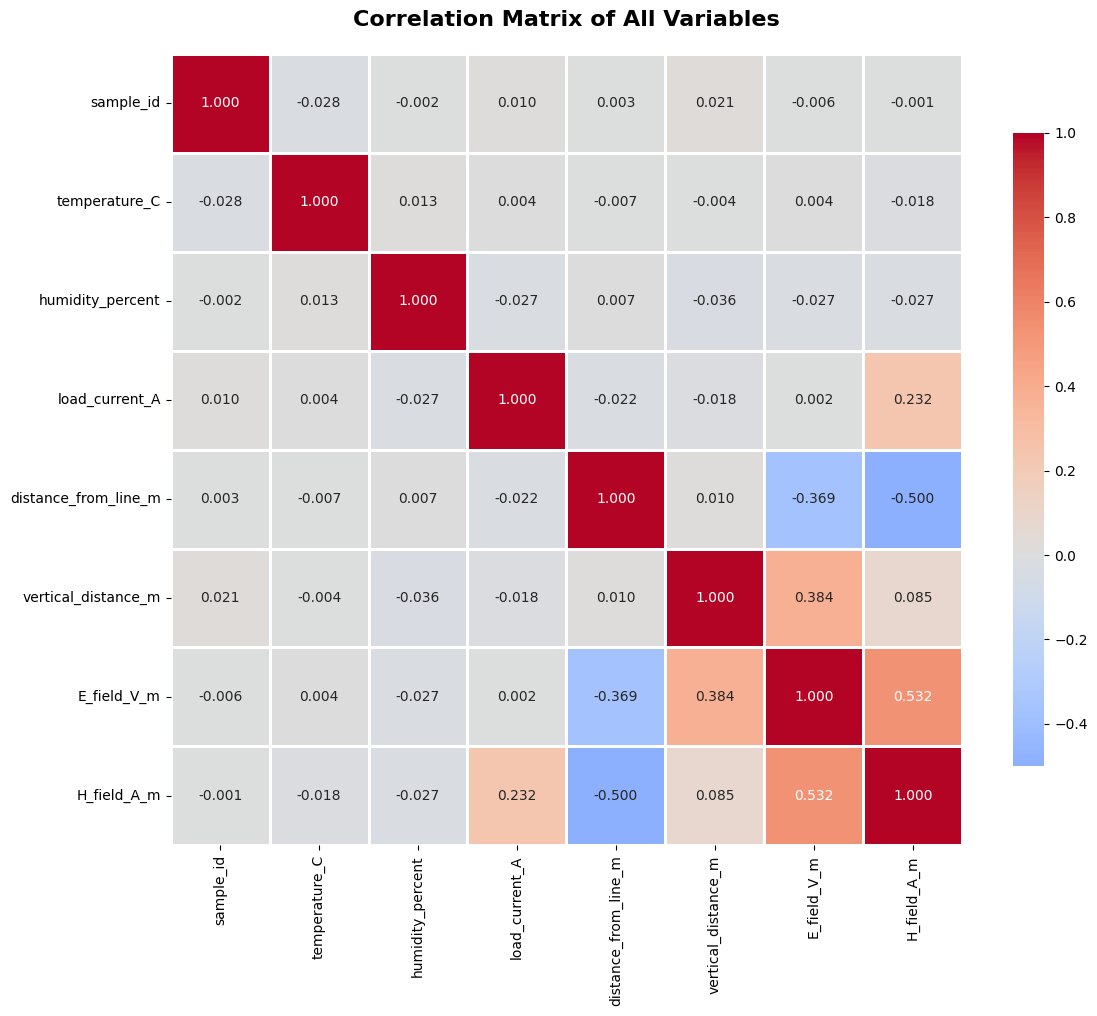


Key Correlations with E Field:
E_field_V_m             1.000000
H_field_A_m             0.532090
vertical_distance_m     0.383833
temperature_C           0.004262
load_current_A          0.002220
sample_id              -0.006436
humidity_percent       -0.027352
distance_from_line_m   -0.369416
Name: E_field_V_m, dtype: float64

Key Correlations with H Field:
H_field_A_m             1.000000
E_field_V_m             0.532090
load_current_A          0.232290
vertical_distance_m     0.084714
sample_id              -0.001001
temperature_C          -0.018325
humidity_percent       -0.027340
distance_from_line_m   -0.500405
Name: H_field_A_m, dtype: float64


In [12]:
# Calculate correlation matrix (excluding non-numeric columns)
numeric_data = final_data.select_dtypes(include=[np.number])
correlation_matrix = numeric_data.corr()

# Create heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            fmt='.3f', square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of All Variables', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Print key correlations with E and H fields
print("\nKey Correlations with E Field:")
print(correlation_matrix['E_field_V_m'].sort_values(ascending=False))
print("\nKey Correlations with H Field:")
print(correlation_matrix['H_field_A_m'].sort_values(ascending=False))

### 9.5 Box Plots - Effects of Weather on EMF

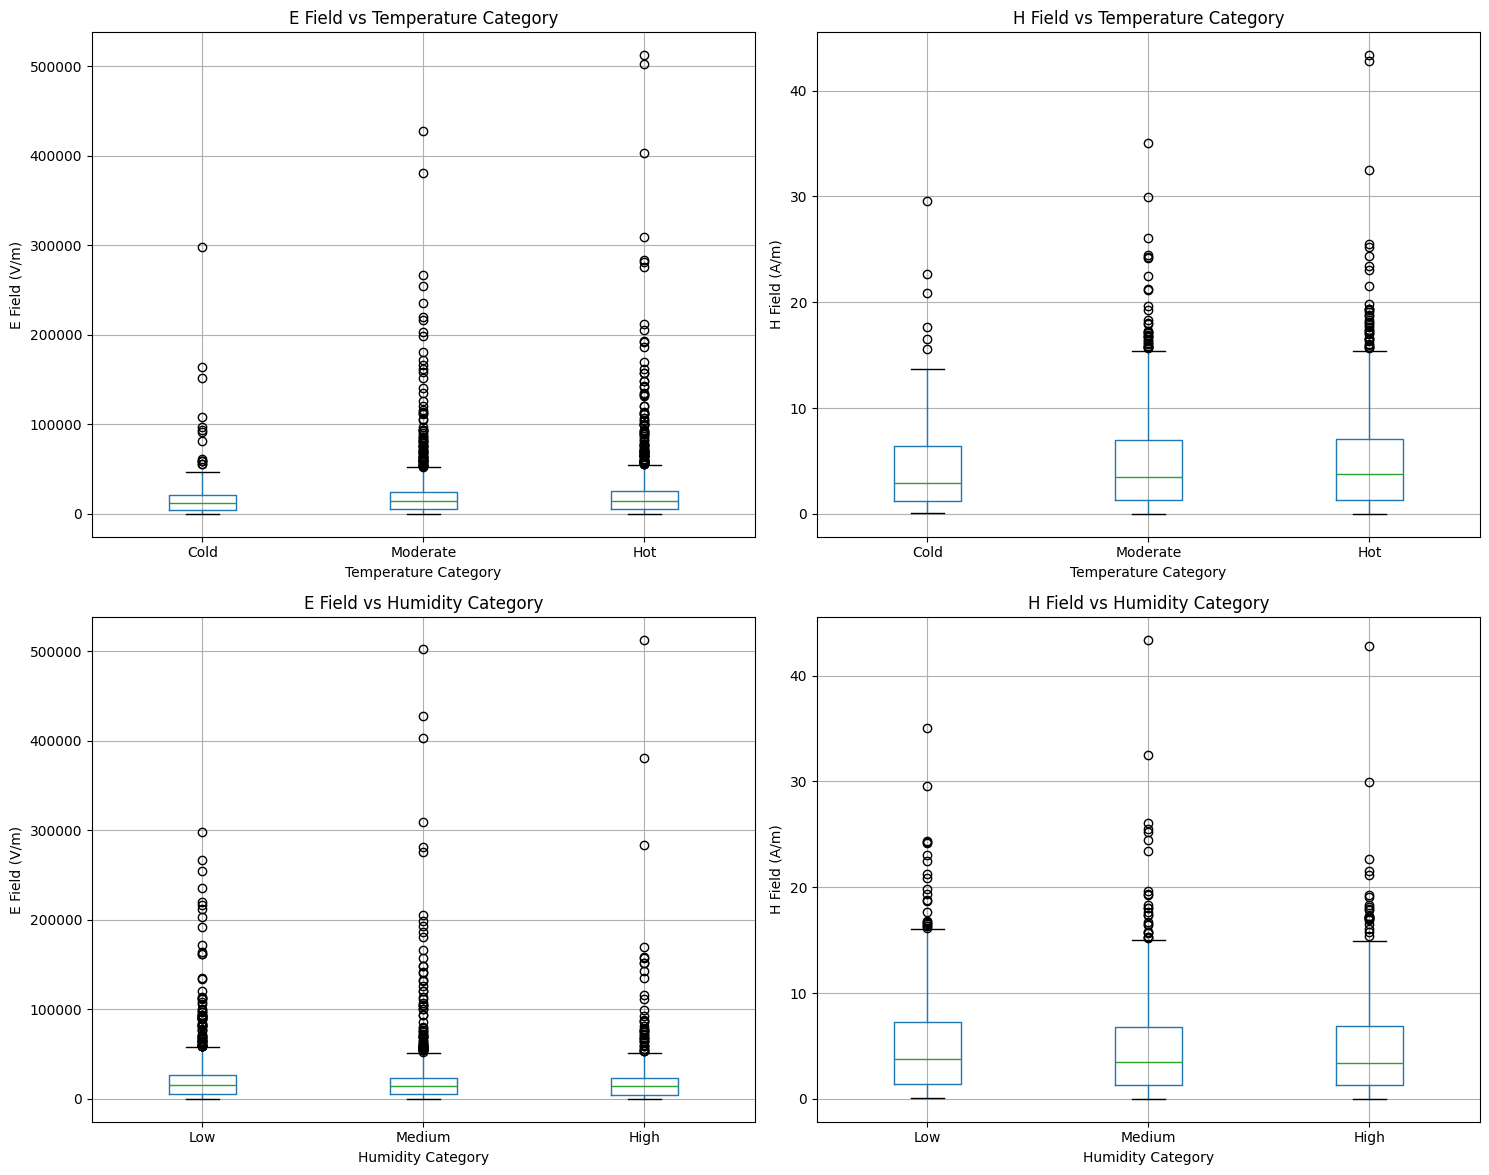

In [13]:
# Create temperature and humidity bins for analysis
final_data['temp_category'] = pd.cut(final_data['temperature_C'], 
                                       bins=[-np.inf, 10, 25, np.inf], 
                                       labels=['Cold', 'Moderate', 'Hot'])

final_data['humidity_category'] = pd.cut(final_data['humidity_percent'], 
                                           bins=[0, 40, 70, 100], 
                                           labels=['Low', 'Medium', 'High'])

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Weather Effects on EMF (Excluding Outliers)', fontsize=16, fontweight='bold')

# Filter out outliers for cleaner visualization
clean_data = final_data[~final_data['is_outlier']]

# Temperature effect on E field
clean_data.boxplot(column='E_field_V_m', by='temp_category', ax=axes[0, 0])
axes[0, 0].set_title('E Field vs Temperature Category')
axes[0, 0].set_xlabel('Temperature Category')
axes[0, 0].set_ylabel('E Field (V/m)')
axes[0, 0].get_figure().suptitle('')

# Temperature effect on H field
clean_data.boxplot(column='H_field_A_m', by='temp_category', ax=axes[0, 1])
axes[0, 1].set_title('H Field vs Temperature Category')
axes[0, 1].set_xlabel('Temperature Category')
axes[0, 1].set_ylabel('H Field (A/m)')
axes[0, 1].get_figure().suptitle('')

# Humidity effect on E field
clean_data.boxplot(column='E_field_V_m', by='humidity_category', ax=axes[1, 0])
axes[1, 0].set_title('E Field vs Humidity Category')
axes[1, 0].set_xlabel('Humidity Category')
axes[1, 0].set_ylabel('E Field (V/m)')
axes[1, 0].get_figure().suptitle('')

# Humidity effect on H field
clean_data.boxplot(column='H_field_A_m', by='humidity_category', ax=axes[1, 1])
axes[1, 1].set_title('H Field vs Humidity Category')
axes[1, 1].set_xlabel('Humidity Category')
axes[1, 1].set_ylabel('H Field (A/m)')
axes[1, 1].get_figure().suptitle('')

plt.tight_layout()
plt.show()

### 9.6 3D Visualization - E Field vs Distance and Load

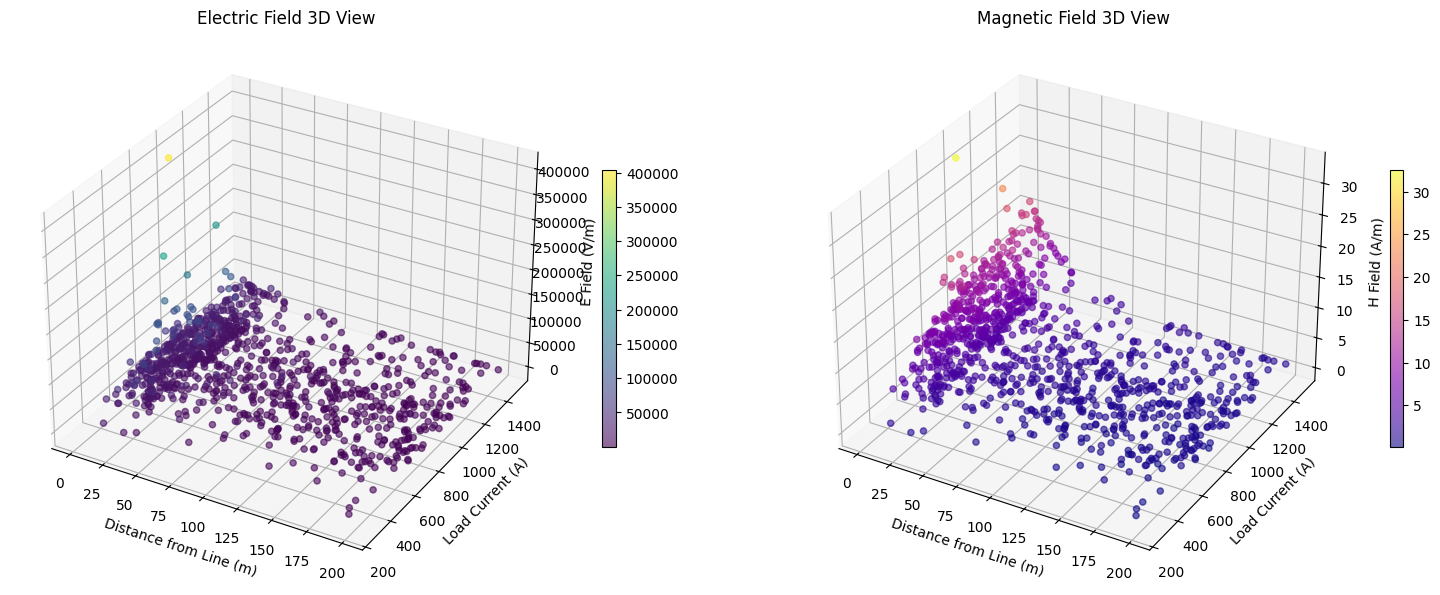

In [14]:
from mpl_toolkits.mplot3d import Axes3D

# Sample subset for clearer 3D visualization
sample_size = 1000
sample_indices = np.random.choice(len(clean_data), sample_size, replace=False)
sample_data = clean_data.iloc[sample_indices]

fig = plt.figure(figsize=(16, 6))

# 3D plot for E field
ax1 = fig.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(sample_data['distance_from_line_m'], 
                       sample_data['load_current_A'], 
                       sample_data['E_field_V_m'],
                       c=sample_data['E_field_V_m'], 
                       cmap='viridis', 
                       alpha=0.6, 
                       s=20)
ax1.set_xlabel('Distance from Line (m)')
ax1.set_ylabel('Load Current (A)')
ax1.set_zlabel('E Field (V/m)')
ax1.set_title('Electric Field 3D View')
plt.colorbar(scatter1, ax=ax1, shrink=0.5)

# 3D plot for H field
ax2 = fig.add_subplot(122, projection='3d')
scatter2 = ax2.scatter(sample_data['distance_from_line_m'], 
                       sample_data['load_current_A'], 
                       sample_data['H_field_A_m'],
                       c=sample_data['H_field_A_m'], 
                       cmap='plasma', 
                       alpha=0.6, 
                       s=20)
ax2.set_xlabel('Distance from Line (m)')
ax2.set_ylabel('Load Current (A)')
ax2.set_zlabel('H Field (A/m)')
ax2.set_title('Magnetic Field 3D View')
plt.colorbar(scatter2, ax=ax2, shrink=0.5)

plt.tight_layout()
plt.show()

## Summary

✅ **Dataset Successfully Generated!**

### Dataset Features:
- **Total Samples**: 5,000
- **Input Features**:
  1. Temperature (°C)
  2. Humidity (%)
  3. Load Current (A)
  4. Distance from Transmission Line (m)
  5. Vertical Distance (m)
  
- **Output Variables**:
  1. Electric Field E (V/m)
  2. Magnetic Field H (A/m)

### Data Characteristics:
- ✓ Based on real transmission line physics equations
- ✓ Includes realistic weather parameters
- ✓ Contains ~5% Gaussian noise
- ✓ Includes ~3% outliers
- ✓ Covers various measurement scenarios (ground level, elevated, close, far)

### File Saved:
**EMF_Synthetic_Data.csv** - Ready for machine learning analysis!